# OAD data preprocessing flow

The notebook provides an example of how one can use OADlib to preprocess OAD data for training a LSTM-based model. For the example we will take real experimental data from `OADlib/data/raw/` directory. The raw data consists of several experiments with different CH4 concentrations in N2 atmosphere. We will use the temperature data (`"Temp"`) and temperature derivative over time in order to predict the resonance frequency (`"Fres"`). Since we are going to use LSTM-based models, we will pass data about temperature and its derivative over time for the previous `N` points in order to predict resonance frequency at the given point. 

The preprocessing includes the folowwing steps:

1. Data series smoothing
2. Derivative computation (i.e. d(Temp)/d(time))
3. Data normalization
4. Grouping data for different values of parameter `N`
5. Splitting data into train/valid/test sets

We will use `Preprocessing` class from `OADlib/preprocessing/data_preprocessing.py` for that purposes.

In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
import os
import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14, 7)
plt.rcParams["font.size"] = 12
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 14

oadlib_path = f"{os.path.abspath('')}/../"

# Adding OADlib folder to path
sys.path.append(oadlib_path)
sys.path.append(f'{oadlib_path}/../')

In [76]:
from OADlib.preprocessing.data_preprocessing import Preprocessing

# 0. Looking and the raw data and creating data preprocessing object

Specifying directory with raw data, looking at what data we have and creating an instance of `Preprocessing` class for data preprocessing.

,Time,Fres,Temp
0,0,1780.79,25.03
1,2,1803.24,24.75
2,4,1810.65,25.16
3,6,1805.87,24.96
4,8,1798.90,25.05


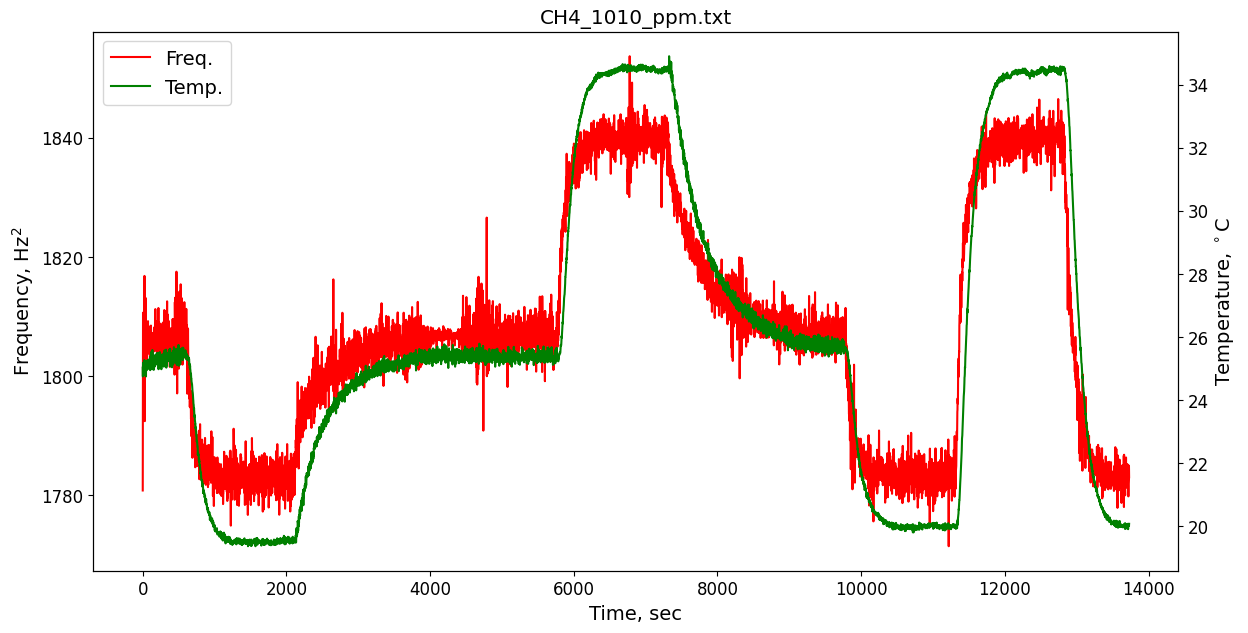

In [77]:
raw_data_dir = "raw/"  # Directory with raw data

# Taking the experiment with 1010 ppm CH4 to look at
exp_filename = "CH4_1010_ppm.txt"
df = pd.read_csv(f"{raw_data_dir}/{exp_filename}", sep="\t")
display(df.head())

_, ax1 = plt.subplots()
ax2 = ax1.twinx()

plt_fres, = ax1.plot(df['Time'], df['Fres'], color='red')
plt_temp, = ax2.plot(df['Time'], df['Temp'], color='green')

ax1.legend((plt_fres, plt_temp), ('Freq.', 'Temp.'), loc='upper left')

ax1.set_xlabel('Time, sec')
ax1.set_ylabel('Frequency, Hz$^2$')
ax2.set_ylabel('Temperature, $^\circ$C')
plt.title(exp_filename)
plt.show()

# Data preprocessin object
preprocessing = Preprocessing(data_dir=raw_data_dir)

# 1. Data series smoothing

In the step, we will use `preprocessing.smooth()` method to smooth the initial `"Fres"` data with `SimpleMovingAverage` smoothing algorithm with window of **15** samples. Note that *in demonstrative purposes*, all the files from `OADlib/data/raw/` directory were manually listed below. See docs of `Preprocessing.smooth()` for more details.

The code below executes smoothing algorithm over all files from `OADlib/data/raw/` directory and stores files with smoothed `Fres` column in `OADlib/data/smoothed/` directory. The saved files have `*.csv` extension. Note that first `window_size - 1` values of `"Fres"` column are set to `NaN`, that why `dropna()` is used.

In [78]:
from OADlib.preprocessing.smoothing.simple_moving_average import SimpleMovingAverage

In [79]:
window_size = 15
smoothed_data_dir = "smoothed/"

preprocessing.smooth(
    smoother=SimpleMovingAverage(window_size),
    col_name="Fres",  # Specifying the column to smooth data from
    save_to=smoothed_data_dir,
    # Specifying the files to use for smoothing. In demonstrative purposes, all the files from "raw/" directory are listed below.
    # The effect of that will be the same as not specifying "use_files" at all.
    use_files=("CH4_2_ppm.txt", "CH4_9.7_ppm.txt", "CH4_97_ppm.txt", "CH4_1010_ppm.txt"),
    sep="\t"
)

,Time,Unsmoothed Fres,Temp,Fres
14,28,1792.43,24.97,1802.976000
15,30,1809.97,25.16,1804.921333
16,32,1800.25,25.06,1804.722000
17,34,1806.09,24.92,1804.418000
18,37,1805.55,24.79,1804.396667


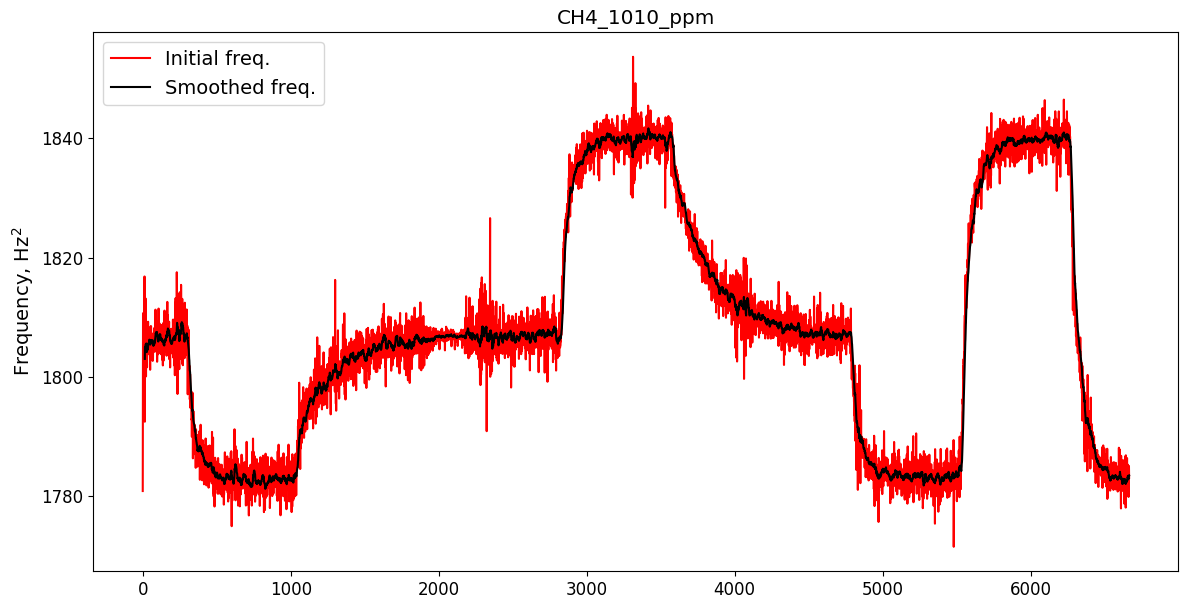

In [80]:
# Let's look how we smoothed resonance frequency for the experiment with 1010 ppm CH4
exp_name = "CH4_1010_ppm"
init_df = pd.read_csv(f"{raw_data_dir}/{exp_name}.txt", sep="\t")
smoothed_df = pd.read_csv(f"{smoothed_data_dir}/{exp_name}.csv").dropna()
display(smoothed_df.head())

initial_freq = init_df['Fres']
smoothed_freq = smoothed_df['Fres']

plt.plot(initial_freq, label='Initial freq.', color="red")
plt.plot(smoothed_freq, label='Smoothed freq.', color="black")
plt.ylabel("Frequency, Hz$^2$")
plt.title(exp_name)
plt.legend()
plt.show()

# 2. Computing derivative dT/dt

Now let's compute derivative `dT/dt`, where `T` stands for column `Temp` (temperature), `t` stand for column `Time`. To do so we will use `preprocessing.compute_derivatives()` method with `PolyfitDerivative` algorithm with the fitting polynominal degree (`poly_deg`) of **1** and the number of interpolating points (`n_points`) of **15**. Since we stored the smoothed data in `OADlib/data/smoothed/` directory, we will specify that directory in `load_from` parameter. The computed derivative will be stored in dataframes under `"dT/dt"` column in `OADlib/data/computed_derivatives/` directory. Note that now the `use_files` parameters stays unspecified, so each file from `load_from` directory will be used. Note that first `n_points - 1` values of `"dT/dt"` column are set to `NaN`, that why `dropna()` is used.

In [81]:
from OADlib.preprocessing.derivative_computation.polyfit_derivative import PolyfitDerivative

In [82]:
poly_deg = 1
n_points = 15
computed_derivatives_data_dir = "computed_derivatives/"

preprocessing.compute_derivatives(
    deriv_computer=PolyfitDerivative(poly_deg=poly_deg, n_points=n_points),
    x_col_name="Time",
    y_col_name="Temp",
    deriv_col_name="dT/dt",
    save_to=computed_derivatives_data_dir,
    load_from=smoothed_data_dir
)

,Time,Unsmoothed Fres,Temp,Fres,dT/dt
14,28,1792.43,24.97,1802.976000,0.005839
15,30,1809.97,25.16,1804.921333,0.006411
16,32,1800.25,25.06,1804.722000,0.001500
17,34,1806.09,24.92,1804.418000,0.000143
18,37,1805.55,24.79,1804.396667,-0.005380


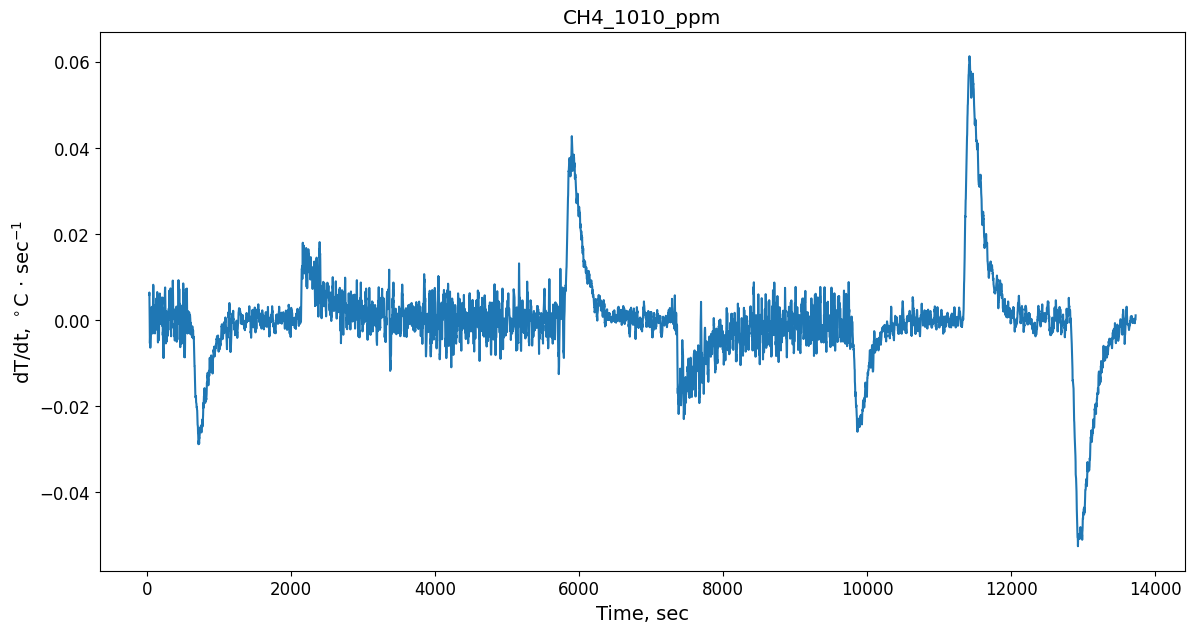

In [83]:
# Let's look how we computed the dT/dt derivative for the experiment with 1010 ppm CH4
exp_name = "CH4_1010_ppm"
deriv_df = pd.read_csv(f"{computed_derivatives_data_dir}/{exp_name}.csv").dropna()
display(deriv_df.head())

plt.plot(deriv_df["Time"], deriv_df["dT/dt"])
plt.xlabel("Time, sec")
plt.ylabel("dT/dt, $^\circ$C $\cdot$ sec$^{-1}$")
plt.title(exp_name)
plt.show()

# 3. Normalization

We are going to use values from columns `Temp`, `dT/dt` to reconstruct the resonance frequency (i.e. values from column `Fres`), but before that we have to normaliza data in all these columns.

Let's normalize the values from `Temp` by a standart method: `x' = (x - mean(x)) / std(x)`, where mean and std will be calculated over all samples from all the files in `OADlib/data/computed_derivatives/` directory (and same for `dT/dt`).

Normalization of the `Fres` will be simpler: we will just divide each valued over `1000`.

The normalizaed dataframes will be stored in `OADlib/data/normalized`. The mean and std values, as well as normalization factor for frequency, are printed at the end in order to not forget them.

In [84]:
temp_samples = np.array([])
temp_deriv_samples = np.array([])

for filename in os.listdir(computed_derivatives_data_dir):
    df = pd.read_csv(f"{computed_derivatives_data_dir}/{filename}").dropna()

    temp_samples = np.append(temp_samples, df['Temp'])
    temp_deriv_samples = np.append(temp_deriv_samples, df['dT/dt'])

mean_temp, std_temp = np.mean(temp_samples), np.std(temp_samples)
mean_temp_deriv, std_temp_deriv = np.mean(temp_deriv_samples), np.std(temp_deriv_samples)

# Normalizing and saving data
norm_data_dir = "normalized/"
freq_norm_factor = 1.0 / 1000

for filename in os.listdir(computed_derivatives_data_dir):
    df = pd.read_csv(f"{computed_derivatives_data_dir}/{filename}").dropna()

    df['Temp'] = (df['Temp'] - mean_temp) / std_temp
    df['dT/dt'] = (df['dT/dt'] - mean_temp_deriv) / std_temp_deriv

    df['Fres'] = df['Fres'] * freq_norm_factor

    df.to_csv(f"{norm_data_dir}/{filename}", index=False)

print(f"mean temp: {mean_temp}, std temp: {std_temp}")
print(f"mean temp deriv: {mean_temp_deriv}, std temp deriv: {std_temp_deriv}")
print(f"freq norm factor: {freq_norm_factor}")

mean temp: 25.902733232284962, std temp: 4.859121218958875
mean temp deriv: -0.0004038538111712432, std temp deriv: 0.01090840730995394
freq norm factor: 0.001


In [85]:
# Let's check what we have now
pd.read_csv(f"{norm_data_dir}/CH4_1010_ppm.csv").head()

,Time,Unsmoothed Fres,Temp,Fres,dT/dt
0,28,1792.43,-0.191955,1.802976,0.572324
1,30,1809.97,-0.152853,1.804921,0.624708
2,32,1800.25,-0.173433,1.804722,0.174531
3,34,1806.09,-0.202245,1.804418,0.050118
4,37,1805.55,-0.228999,1.804397,-0.456181


# 4. Grouping data

Since we are going to use LSTM-based models to predict `Fres` by both `Temp` and `dT/dt`, we have to group the samples in a particular order: slices `Temp[i - N:i]`, `dT/dt[i - N:i]` must be mapped to the value `Fres[i - 1]`. To perform such grouping, we will use `preprocessing.group_by()` method. For demonstrative purposes, only experiment with 1010 ppm CH4 will be used. The grouped data will be stored in `OADlib/data/seq_grouped/CH4_1010_ppm/` in `*.npz` archives. For future needs, we will create groups for `N` in `[1, 10]`.

In [86]:
exp_name = "CH4_1010_ppm"
grouped_data_dir = f"seq_grouped/{exp_name}"

for seq_len in range(1, 11):  #  seq_len stands for `N`
    preprocessing.group_by(
        seq_len=seq_len,
        group_columns=("Temp", "dT/dt"),
        target_columns=("Fres", "Time"),  # Let's map to "Time" too
        save_to=grouped_data_dir,
        load_from=norm_data_dir,
        use_files=(f"{exp_name}.csv",)
    )

In [87]:
# Let's check what we have grouped
seq_len = 5
grouped_data = np.load(f"{grouped_data_dir}/{seq_len}_points.npz")

for key in grouped_data.keys():
    print(f"{key}: {grouped_data[key]}, shape = {grouped_data[key].shape}")

idx = 99
grouped_data['Fres'][idx], grouped_data['Time'][idx], grouped_data['Temp'][idx], grouped_data['dT/dt'][idx]

Fres: [1.80439667 1.80534533 1.80541533 ... 1.78324533 1.783416   1.78342467], shape = (6648,)
Time: [   37    39    41 ... 13726 13728 13730], shape = (6648,)
Temp: [[-0.19195513 -0.15285341 -0.17343326 -0.20224505 -0.22899886]
 [-0.15285341 -0.17343326 -0.20224505 -0.22899886 -0.14667945]
 [-0.17343326 -0.20224505 -0.22899886 -0.14667945 -0.14462147]
 ...
 [-1.23329569 -1.21888979 -1.20036792 -1.20448389 -1.20859986]
 [-1.21888979 -1.20036792 -1.20448389 -1.20859986 -1.21271583]
 [-1.20036792 -1.20448389 -1.20859986 -1.21271583 -1.19830994]], shape = (6648, 5)
dT/dt: [[ 0.57232365  0.62470789  0.17453087  0.05011831 -0.45618106]
 [ 0.62470789  0.17453087  0.05011831 -0.45618106 -0.33485345]
 [ 0.17453087  0.05011831 -0.45618106 -0.33485345 -0.05692201]
 ...
 [-0.00593324 -0.00426452 -0.02875599  0.04874908  0.04096067]
 [-0.00426452 -0.02875599  0.04874908  0.04096067  0.04886366]
 [-0.02875599  0.04874908  0.04096067  0.04886366  0.13935333]], shape = (6648, 5)


(1.806966,
 239,
 array([-0.11580967, -0.08288191, -0.14462147, -0.15696938, -0.07876594]),
 array([-0.52283426,  0.10413955,  0.29566941,  0.14510995,  0.51605564]))

# 5. Train/Valid/Test split

The final step: splitting the grouped data into train/valid/test sets using `preprocessing.train_valid_test_split()`. We will split the data in proportions of 70/15/15 %, respectively. Again, we will split data from all the `*.npz` archives prepared on the previous step for the 1010 ppm CH4 and store the datasets in the `OADlib/data/datasets/CH4_1010_ppm/` in `*.pth` files using `torch` library.

In [88]:
exp_name = "CH4_1010_ppm"
dataset_dir = f"datasets/{exp_name}"

train_size, valid_size, test_size = 0.7, 0.15, 0.15

preprocessing.train_valid_test_split(
    load_from=grouped_data_dir,
    train_size=train_size,
    valid_size=valid_size,
    test_size=test_size,
    save_to=dataset_dir
)

In [89]:
# Let's check the datasets
seq_len = 5
dataset = torch.load(f"{dataset_dir}/dataset_{seq_len}_points.pth")

print(f"keys: {dataset.keys()}")
print()
print(f"train: {dataset['train']}")
print()
print(f"train len: {len(dataset['train']['Time'])}, valid len: {len(dataset['valid']['Time'])}, test len: {len(dataset['test']['Time'])}")
print()

id = 123
mode = 'train'
print(f"Samples from \"{mode}\" at index {id}:")
for key in ('Fres', 'Time', 'Temp', 'dT/dt'):
    print(f"{key}: {dataset[mode][key][id]}")

keys: dict_keys(['train', 'valid', 'test'])

train: {'Fres': array([1.807886  , 1.78314133, 1.81401667, ..., 1.78329133, 1.78253933,
       1.78317133]), 'Time': array([ 9375, 10438,  8023, ..., 10732, 11067,  1792]), 'Temp': array([[-0.04378019,  0.02413333, -0.03966422, -0.03966422, -0.0273163 ],
       [-1.21477382, -1.21477382, -1.21477382, -1.23329569, -1.19213598],
       [ 0.41720852,  0.42955643,  0.4336724 ,  0.40280262,  0.37193284],
       ...,
       [-1.20242591, -1.23535367, -1.2168318 , -1.25387554, -1.24358561],
       [-1.20859986, -1.21477382, -1.21477382, -1.22094777, -1.2168318 ],
       [-1.33825293, -1.30532517, -1.33002099, -1.32178905, -1.32384704]]), 'dT/dt': array([[-0.42625083, -0.40496973, -0.26724036, -0.31038109, -0.28687056],
       [-0.18233673, -0.15048224, -0.13314873, -0.25683941, -0.13735637],
       [-0.68653499, -0.54738937, -0.28219418, -0.38041462, -0.38696265],
       ...,
       [ 0.07303641,  0.05175532,  0.05502933, -0.17415169, -0.27892016],

# By that point we have created datasets that can be passed to `OADDataset` class and used in the training process.

See `OADlib/optuna_example/` for more details.